In [1]:
import numpy as np
import networkx as nx
import json

import tqdm as tqdm

from simplequantnetsim.protocols import MPC_protocol, MPG_protocol, SP_protocol
from simplequantnetsim.graph import network, set_edge_length, update_graph_params, reset_graph_state, reset_graph_usage, remove_nodes, set_p_edge
from simplequantnetsim.graph_manager import load_from_file

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from networkx.drawing.layout import *
from networkx.readwrite import json_graph

# Helpers

## Draw network

In [2]:
# def read_network(file_path, encoding='utf-8'):
#     G = nx.Graph()
#     with open(file_path, 'r', encoding=encoding) as f:
#         lines = f.readlines()[1:]  # Skip header line
#         for line in lines:
#             parts = line.strip().split()
#             origen = int(parts[0])
#             destino = int(parts[1])
#             distancia = float(parts[2])
#             MTBF = float(parts[3])
#             MTTR = float(parts[4])
#             G.add_edge(origen, destino, distancia=distancia, MTBF=MTBF, MTTR=MTTR)
#     return G

# def draw_network(G, size="l"):
#     usage = nx.get_node_attributes(G, "usage_fraction")
    
#     # If there are no usage_fraction attributes, create dummy ones for visualization
#     if not usage:
#         for node in G.nodes():
#             G.nodes[node]["usage_fraction"] = 0.5  # You can adjust this value as needed
#         usage = nx.get_node_attributes(G, "usage_fraction")
    
#     pos = nx.spring_layout(G)  # Using spring layout for better visualization

#     cmap = plt.cm.Blues
#     cmap.set_under(color="white")  # Display zero fraction (under 0.0000001) as white

#     nc = nx.draw(
#         G,
#         pos=pos,
#         with_labels=draw_options[size]["with_labels"],
#         node_size=draw_options[size]["node_size"],
#         font_size=draw_options[size]["font_size"],
#         node_color=list(usage.values()),
#         vmin=0.0000001,
#         cmap=cmap,
#     )

#     # Colorbar
#     ax = plt.gca()
#     PCM = ax.get_children()[0]
#     cbar = plt.colorbar(PCM, ax=ax)
#     cbar.set_label("Usage fraction (/rep)", rotation=270, fontsize=12, labelpad=15)

#     # Usage labels
#     pos_usage = {}
#     for node, coords in pos.items():
#         pos_usage[node] = (coords[0] + draw_options[size]["label_offset"], coords[1] - draw_options[size]["label_offset"])

#     rounded_usage = {}
#     for node, attr in usage.items():
#         rounded_usage[node] = round(attr, 2)

#     nx.draw_networkx_labels(G, pos_usage, labels=rounded_usage, font_size=draw_options[size]["label_size"])

# # Define drawing options
# draw_options = {
#     "l": {
#         "with_labels": True,
#         "node_size": 1000,
#         "font_size": 10,
#         "label_offset": 0.25,
#         "label_size": 8
#     }, # 5x5
#     "m": {
#         "with_labels": True,
#         "node_size": 500,
#         "font_size": 8,
#         "label_offset": 0.1,
#         "label_size": 6
#     }, # 9x9
#     "s": {
#         "with_labels": False,
#         "node_size": 250,
#         "font_size": 0,
#         "label_offset": 0,
#         "label_size": 6
#     }, # 15x15
#     "xs": {
#         "with_labels": False,
#         "node_size": 80,
#         "font_size": 0,        
#         "label_offset": 0,        
#         "label_size": 4
#     } # 25x25
# }

# # Read file paths
# files = {
#     # "ARPAnet": "graphs/ARPAnet_distancia_MTBF_MTTR.txt",
#     # "EON": "graphs/EON_distancia_MTBF_MTTR.txt",
#     "Eurocore": "graphs/Eurocore.txt",
#     # "NSFnet": "graphs/NSFnet.txt",
#     # "UKnet": "graphs/UKnet.txt",
#     # "USnet": "graphs/USnet.txt"
# }

# # Try different encodings to read files and draw network
# encodings = ['utf-8', 'latin-1', 'ISO-8859-1']
# for name, file_path in files.items():
#     for encoding in encodings:
#         try:
#             G = read_network(file_path, encoding=encoding)
#             print(f"Drawing network for {name} using encoding {encoding}")
#             draw_network(G, size="m")
#             break  # Successfully read, break the loop
#         except UnicodeDecodeError:
#             print(f"Failed to read {name} with encoding {encoding}")


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def read_network(file_path, encoding='utf-8'):
    G = nx.Graph()
    with open(file_path, 'r', encoding=encoding) as f:
        lines = f.readlines()[1:]  # Skip header line
        for line in lines:
            parts = line.strip().split()
            origen = int(parts[0])
            destino = int(parts[1])
            distancia = float(parts[2])
            MTBF = float(parts[3])
            MTTR = float(parts[4])
            G.add_edge(origen, destino, distancia=distancia, MTBF=MTBF, MTTR=MTTR)
    return G

def draw_network(G, size="l", layout=None):
    usage = nx.get_node_attributes(G, "usage_fraction")
    
    if not usage:
        for node in G.nodes():
            G.nodes[node]["usage_fraction"] = 0.5  # You can adjust this value as needed
        usage = nx.get_node_attributes(G, "usage_fraction")
    
    cmap = plt.cm.Blues
    cmap.set_under(color="white")  # Display zero fraction (under 0.0000001) as white

    # 使用传入的布局绘制网络
    nc = nx.draw(
        G,
        pos=layout,
        with_labels=draw_options[size]["with_labels"],
        node_size=draw_options[size]["node_size"],
        font_size=draw_options[size]["font_size"],
        node_color=list(usage.values()),
        vmin=0.0000001,
        cmap=cmap,
    )

    ax = plt.gca()
    PCM = ax.get_children()[0]
    cbar = plt.colorbar(PCM, ax=ax)
    cbar.set_label("Usage fraction (/rep)", rotation=270, fontsize=12, labelpad=15)

    pos_usage = {}
    for node, coords in layout.items():
        pos_usage[node] = (coords[0] + draw_options[size]["label_offset"], coords[1] - draw_options[size]["label_offset"])

    rounded_usage = {}
    for node, attr in usage.items():
        rounded_usage[node] = round(attr, 2)

    nx.draw_networkx_labels(G, pos_usage, labels=rounded_usage, font_size=draw_options[size]["label_size"])

draw_options = {
    "l": {
        "with_labels": True,
        "node_size": 1000,
        "font_size": 10,
        "label_offset": 0.25,
        "label_size": 8
    },
    "m": {
        "with_labels": True,
        "node_size": 300,
        "font_size": 8,
        "label_offset": 0.05,
        "label_size": 6
    },
    "s": {
        "with_labels": False,
        "node_size": 250,
        "font_size": 0,
        "label_offset": 0,
        "label_size": 6
    },
    "xs": {
        "with_labels": False,
        "node_size": 80,
        "font_size": 0,        
        "label_offset": 0,        
        "label_size": 4
    }
}

## Plot ER v min usage

In [4]:
def plot_removed_repeaters(min_usage_range, ER_range, repeaters_removed, base_ER):
    fontsize = 12
    plt.figure(figsize=(10, 6), dpi=600)
    plt.grid(linewidth=0.5)

    ax = plt.gca()
    sc = ax.scatter(min_usage_range, ER_range, c=repeaters_removed, marker="x", s=40)

    plt.tick_params(labelsize=fontsize)
    plt.xlabel("Minimum usage fraction (/rep)", fontsize=fontsize)
    plt.ylabel("DR ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

    for i, txt in enumerate(repeaters_removed):
        ax.annotate(
            txt,
            xy=(min_usage_range[i], ER_range[i]),
            xycoords="data",
            xytext=(3, -6),
            textcoords="offset points",
            fontsize=6,
            weight='bold'
        )

    # plot original ER
    plt.axhline(
        y=base_ER,
        color="black",
        linestyle="--",
        linewidth="1",
        label="Base ER",
    )
    plt.legend(fontsize=10)

    cbar = plt.colorbar(sc)
    cbar.set_label(
        "No. repeaters removed", rotation=270, fontsize=12, labelpad=15
    )

## Plot ER v Operation

In [5]:
def plot_er_p_op(repeaters_removed_list, ER_list, loss_dB, p_op, x_lim=1):
    fontsize = 12
    cols = ["gray", "g", "b", "orange", "r", "k", "purple"] + ["k"] * 100

    plt.figure(figsize=(8, 6), dpi=600)
    plt.grid(linewidth=0.5)
    
    for i in range(len(repeaters_removed_list)):
        y = plt.plot(
            p_op,
            ER_list[i],
            color=cols[i],
            marker="x",
            linestyle="None",
            markersize=3,
            label=repeaters_removed_list[i],
        )
    plt.yscale("log")
    plt.legend(fontsize=10, title="No. repeaters removed", title_fontsize=8)

    plt.tick_params(labelsize=fontsize)

    plt.xlabel("Perfect operations probability $p_{op}$", fontsize=fontsize)
    plt.ylabel("DR ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

    ax = plt.gca()
    # l_ticks = ax.get_xticks()
    ax.set_xlim([0, x_lim])
    ax.set_ylim([0.0001, 1])

    # length2p_ph = lambda l: 10 ** -(loss_dB * l / 10)
    # p_ph2length = lambda p: -(np.log10(p) * 10) / loss_dB
    # ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
    # ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)
    # p_ph_ticks = length2p_ph(l_ticks)
    # ax2.set_xticks(p_ph_ticks)
    # ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    # ax2.xaxis.set_tick_params(labelsize=fontsize)

    # length2p_e = lambda l: length2p_ph(l) * p_op
    # p_e2length = lambda p: p_ph2length(p / p_op)
    # ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
    # ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)
    # p_e_ticks = length2p_e(l_ticks)
    # ax3.set_xticks(p_e_ticks)
    # ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    # ax3.xaxis.set_tick_params(labelsize=fontsize)

## Save and load data

In [6]:
def save_data(filename, data):
    with open("data_HS/" + filename + ".json", "w") as file:
        file.write(json.dumps(data))

def load_data(filename):
    with open("data_HS/" + filename + ".json", "r") as file:
        return json.loads(file.read())

# Usage

In [53]:
Mesh_topologies = "NSFnet.txt" # "ARPAnet_distancia_MTBF_MTTR.txt", "EON_distancia_MTBF_MTTR.txt", "Eurocore.txt", "NSFnet.txt". "UKnet.txt". "USnet.txt"
timesteps = 5000
reps = 1000
Q_c = 10
# Q_c = 100000
p_op = 1
loss_dB = 0.2
protocol = SP_protocol# MPC_protocol, MPG_protocol, SP_protocol

H = load_from_file(Mesh_topologies)
# users = [
#     '8',
#     '18',
#     '4',
#     '11',
#     '17',
# ]  # UK

# users = [
#     "8",
#     "15",
#     "19",
#     "1",
#     "2",
# ] # ARPA

# users = [
#     "14",
#     "0",
#     "7",
#     "1",
#     "18",
# ] # EON

# users = [
#     "1",
#     "0",
#     "5",
#     "2",
#     "3",
# ] # Euro

users = [
    "5",
    "1",
    "10",
    "9",
    "6",
] # NSF

# users = [
#     "22",
#     "44",
#     "42",
#     "0",
#     "43",
# ] # US
update_graph_params(H, Qc=Q_c)

set_p_edge(H, p_op, loss_dB)
er, multipartite_gen_time, links_used = protocol(H, users, timesteps, reps, count_fusion=False)

## Draw network

In [ ]:
nodes = H.nodes(data=True)

print(nodes)
usage = nx.get_node_attributes(H, "usage_fraction")
print(list(usage.values()))

In [ ]:
draw_network(H, "m")
# plt.savefig("figures_HS/usage_US_SP_p_op_1_new.png", dpi=600, bbox_inches="tight")

## Save data

In [54]:
data_to_save = {
    "protocol": str(protocol).split(" ")[1],
    "Mesh_topologies": Mesh_topologies,
    "Q_c": Q_c,
    "p_op": p_op,
    "loss_dB": loss_dB,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": er,
    "links_used": links_used,
    "network_data": json_graph.node_link_data(H),
}

save_data("usage/method_reps/NSF/SP_Q10", data_to_save)##########################################

## Load and plot data

In [103]:
file_to_open = "usage/method_reps/NSF/SP_Q10"########################################################

with open("data_HS/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

H_loaded = json_graph.node_link_graph(loaded_data["network_data"])

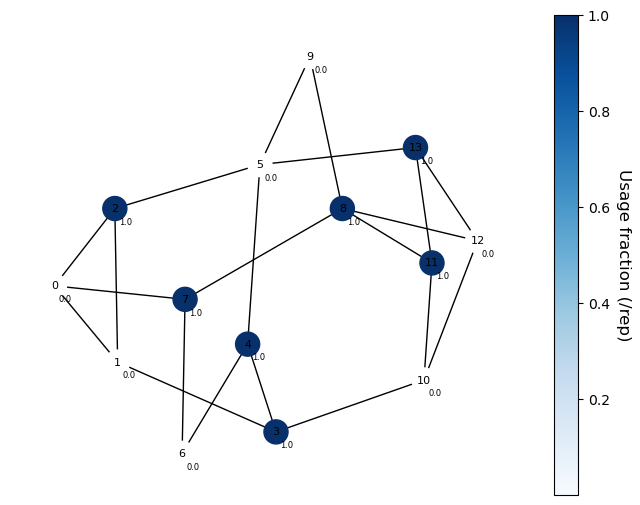

In [104]:
saved_layout = nx.spring_layout(H_loaded, seed = 14)############################################
draw_network(H_loaded, "m", layout=saved_layout)
plt.savefig("figures_HS/Impact of Q_c/usage_NSF_SP_Q10.png", dpi=600, bbox_inches="tight")###############################

# Removing Repeaters

## Individual cases

In [ ]:
loaded_data = load_data("usage/method_reps/US/MPG_p_op_1")###################################################

In [ ]:
N_loaded = json_graph.node_link_graph(loaded_data["network_data"])
users = [user for user in loaded_data["users"]] # users = [tuple(user) for user in loaded_data["users"]]
min_usage = 0.3

num_removed = remove_nodes(N_loaded, min_usage, users)

print(num_removed)

reset_graph_state(N_loaded)
reset_graph_usage(N_loaded)

In [ ]:
timesteps = 5000
reps = 1000
protocol = MPG_protocol ##################################
er, multipartite_gen_time, links_used = protocol(N_loaded, users, timesteps, reps, count_fusion=True)
print(er)

In [ ]:
draw_network(N_loaded, "m", layout=saved_layout)
plt.savefig("figures_HS/Removing Repeaters/usage_remove_US_MPG_p_op_1.png", dpi=600, bbox_inches="tight")##########################

In [ ]:
data_to_save = {
    "min_usage": min_usage,
    "num_removed": num_removed,
    "protocol": str(protocol).split(" ")[1],
    "Mesh_topologies": loaded_data["Mesh_topologies"],
    "Q_c": loaded_data["Q_c"],
    "p_op": loaded_data["p_op"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": er,
    "links_used": links_used,
    "network_data": json_graph.node_link_data(N_loaded),
}

save_data("remove_repeaters/usage/US/MPG_p_op_1_mu0.3", data_to_save)########################################

## Cut-off range

In [ ]:
# loaded_data = load_data("usage/method_reps/25x25/MPG_L1")
loaded_data = load_data("usage/method_reps/US/MPG_p_op_1")####################################################

In [ ]:
timesteps = 5000
reps = 1000
protocol = MPG_protocol
users = [user for user in loaded_data["users"]]

min_usage_range = np.linspace(0, 0.3, 31)
num_removed = np.zeros(len(min_usage_range), dtype=int)
ER = np.zeros(len(min_usage_range))
links_used = np.zeros(len(min_usage_range))

for i, min_usage in enumerate(tqdm.tqdm(min_usage_range)):  # tqdm_notebook
    N_loaded = json_graph.node_link_graph(loaded_data["network_data"])

    removed = remove_nodes(N_loaded, min_usage, users)
    num_removed[i] = removed

    reset_graph_state(N_loaded)
    reset_graph_usage(N_loaded)

    er, multipartite_gen_time, links = protocol(N_loaded, users, timesteps, reps, count_fusion=True)
    ER[i] = er
    links_used[i] = links

### Plot 

In [ ]:
plot_removed_repeaters(
    min_usage_range,
    ER,
    num_removed,
    loaded_data["ER"],
)
# plt.savefig("figures_HS/removed_repeaters.png", dpi=600, bbox_inches="tight")

### Save

In [ ]:
data_to_save = {
    "min_usage_range": min_usage_range.tolist(),
    "num_removed": num_removed.tolist(),
    "protocol": str(protocol).split(" ")[1],
    "Mesh_topologies": loaded_data["Mesh_topologies"],
    "Q_c": loaded_data["Q_c"],
    "p_op": loaded_data["p_op"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": ER.tolist(),
    "base_ER": loaded_data["ER"],
    "links_used": links_used.tolist(),
}

save_data("remove_repeaters/usage/US/MPG_range", data_to_save)#############################################

### Load and plot

In [ ]:
loaded_removed_data = load_data("remove_repeaters/usage/US/MPG_range")#####################################

In [ ]:
plot_removed_repeaters(
    loaded_removed_data["min_usage_range"],
    loaded_removed_data["ER"],
    loaded_removed_data["num_removed"],
    loaded_removed_data["base_ER"],
)
plt.savefig("figures_HS/removed_repeaters_US_MPG.png", dpi=600, bbox_inches="tight")#########################

## ER v Operation 

In [ ]:
loaded_data = load_data("usage/method_reps/US/MPG_p_op_1")##################################################

In [ ]:
timesteps = 1000
reps = 200
protocol = MPG_protocol
# p_op = loaded_data["p_op"]
loss_dB = loaded_data["loss_dB"]
users = [user for user in loaded_data["users"]]

min_usage_options = np.array([0, 0.03, 0.1, 0.2, 0.3])
num_removed = np.zeros(len(min_usage_options), dtype=int)

p_op_range = np.linspace(0, 1, 100)
ER = np.zeros((len(min_usage_options), len(p_op_range)))
links_used = np.zeros((len(min_usage_options), len(p_op_range)))

for i, min_usage in enumerate(min_usage_options):  
    N_loaded = json_graph.node_link_graph(loaded_data["network_data"])
    removed = remove_nodes(N_loaded, min_usage, users)
    num_removed[i] = removed

    for j, p_op in enumerate(tqdm.tqdm(p_op_range)):  # tqdm_notebook
        set_p_edge(N_loaded, p_op, loss_dB=loss_dB)
        reset_graph_state(N_loaded)
        reset_graph_usage(N_loaded)

        # if (length > 17):
        #     break

        er, multipartite_gen_time, links = protocol(N_loaded, users, timesteps=timesteps, reps=reps, count_fusion=True)
        ER[i, j] += er
        links_used[i, j] = links

In [ ]:
data_to_save = {
    "min_usage_options": min_usage_options.tolist(),
    "num_removed": num_removed.tolist(),
    "protocol": str(protocol).split(" ")[1],
    "Mesh_topologies": loaded_data["Mesh_topologies"],
    "Q_c": loaded_data["Q_c"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "datapoints": p_op_range.size,
    "p_op_range": p_op_range.tolist(),
    "ER": ER.tolist(),
    "links_used": links_used.tolist(),
}

save_data("remove_repeaters/DR_p_op/US/MPG", data_to_save)#######################################################

In [ ]:
ER_len_data = load_data("remove_repeaters/DR_p_op/US/MPG")#######################################################

In [ ]:
plot_er_p_op(num_removed, ER, loss_dB=loaded_data["loss_dB"], p_op=p_op_range, x_lim=1)
# plot_er_len(ER_len_data["num_removed"], ER_len_data["ER"], ER_len_data["length_range"], loss_dB=ER_len_data["loss_dB"], p_op=ER_len_data["p_op"], x_lim=30)
plt.savefig("figures_HS/DR_v_p_op_US_MPG.png", dpi=600, bbox_inches="tight")#######################################